In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import interpolate
import numpy as np
import numpy.random as npr
from tqdm import trange
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 

In [2]:
## ---------------------------------------- MODEL CLASS AND FUNCTIONS ---------------------------------------- ##

In [3]:
# ----------- MODEL CLASS ------------- #

# define cnn class
class cnn(nn.Module):
    def __init__(self, numChannels, classes):
        # call the parent constructor
        super(cnn, self).__init__()
        # initialize first set of CONV => POOL => RELU layers
        self.conv1 = nn.Conv2d(in_channels=numChannels, out_channels=200,
            kernel_size=(5,5), stride=2, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3)
        self.relu1 = nn.ReLU(inplace=True)
        
        # initialize second set of CONV => POOL => RELU layers
        self.dropout1 = nn.Dropout(0.6)
        self.conv2 = nn.Conv2d(in_channels=200, out_channels=650,
            kernel_size=(5,5), padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3)
        self.relu2 = nn.ReLU(inplace=True)
                               
        # initialize final set of CONV => POOL => RELU layers
        self.dropout2 = nn.Dropout(0.6)
        self.conv3 = nn.Conv2d(in_channels=650, out_channels=350,
            kernel_size=(5,5), padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3)
        self.relu3 = nn.ReLU(inplace=True)
                               
        # initialize our softmax classifier
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(in_features=1400, out_features=128)
        self.relu4 = nn.ReLU(inplace=True)
            
        self.dropout4 = nn.Dropout(0.6)
        self.fc3 = nn.Linear(in_features=128, out_features=classes)
        self.logSoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)                       
        
        # through final CONV => RELU => POOL layer
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        
        # pass the output to our softmax classifier to get our output
        # predictions
        m = nn.Flatten()
        x = m(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        x = self.dropout4(x)
        x = self.fc3(x)
        output = self.logSoftmax(x)
        # return the output predictions
        return output

In [4]:
# ----------- FUNCTIONS ------------- #
    
# function to reshape images
def change_dataset(changed, dataset, BS):
    ind = min(len(dataset),BS)
    X = np.zeros((ind,300,300,3))
    
    if ind != len(dataset):
        X = dataset[:ind]
        X = X.reshape((ind,300,300,3))
        res = np.zeros((X.shape[0],3,300,300))
        for i in range(X.shape[0]):
            res[i] = np.moveaxis(X[i],-1,0)
        res = interpolate(torch.tensor(res),size=(175,175),mode='bicubic',align_corners=False)
        
        if len(changed) == 1:
            changed = np.vstack([changed,np.array(res)])
            changed = changed [1:]
        else:
            changed = np.vstack([changed,np.array(res)])
        dataset = dataset[ind:]
        
    else:
        X = dataset
        X = X.reshape((ind,300,300,3))
        res = np.zeros((X.shape[0],3,300,300))
        for i in range(X.shape[0]):
            res[i] = np.moveaxis(X[i],-1,0)
        res = interpolate(torch.tensor(res),size=(175,175),mode='bicubic',align_corners=False)
        changed = np.vstack([changed,np.array(res)])
        dataset = np.array([])
    return changed, dataset

# accuracy function
def accuracy(pred, y):
    _, predictions = pred.max(1)
    correct = (predictions == y).sum()
    samples = predictions.size(0)
    return correct/samples

# training function
def train(model, optim, lossFn, loader_train, loader_val, epochs=100, device='cpu'):
    model.to(device)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for e in (t := trange(epochs)):

        # train
        epochloss=0; epochacc=0

        model.train()

        for _, (x,y) in enumerate(loader_train):
            x = x.to(device)
            y = y.to(device)

            # perform a forward pass and calculate the training loss
            # zero out the gradients
            optim.zero_grad()
            pred = model(x)
            loss = lossFn(pred, y)
            # backprop
            loss.backward()
            # find acc
            acc = accuracy(pred, y)
            # update weights
            optim.step()
            epochloss += loss.item()
            epochacc += acc.item()
        train_loss = epochloss/len(loader_train)
        train_acc = epochacc/len(loader_train)

        # evaluate
        epochloss=0; epochacc=0

        model.eval()

        with torch.no_grad():
            for _, (x,y) in enumerate(loader_val):
                x = x.to(device)
                y = y.to(device)
                # make the predictions
                pred = model(x)
                loss = lossFn(pred,y)
                # find acc
                acc = accuracy(pred, y)
                epochloss += loss.item()
                epochacc += acc.item()
        val_loss = epochloss/len(loader_val)
        val_acc = epochacc/len(loader_val)

        # add to lists
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        t.set_description('loss %.2f acc %.3f' % (val_loss, val_acc))
    
    model.to(torch.device('cpu'))    
    return train_losses, train_accs, val_losses, val_accs

In [5]:
## ---------------------------------------- MAIN ---------------------------------------- ##

In [6]:
# ----------- DATA PATHS AND HYPERPARAMETERS ------------- #

train_data_path = '../share/data_train.npy'
train_labels_path = '../share/labels_train.npy'

# define training hyperparameters
INIT_LR = 0.0004
BS = 64
EPOCHS = 100

In [7]:
# ----------- PREPARING DATA ------------- #
# loading Data
dataset = np.load(train_data_path)
t_train = np.load(train_labels_path)
print(f'1. dataset.shape, labels.shape: {dataset.shape, t_train.shape}')

# fixing mislabeled data
location = [880, 165, 558, 2396, 3198, 3715, 3734, 3824, 4412, 5238, 38, 2303, 3127, 3467, 3515, 5404, 6178, 248, 827, 1139, 1799, 2491, 2546, 4533, 6024, 103, 392, 846, 913, 1487, 2971, 3234, 3851, 4008, 4405, 4442, 4952, 5348, 204, 272, 297, 1177, 1198, 1326, 1655, 2156, 2690, 2864, 3450, 5095, 5111, 5186, 5243, 5785, 6106,387, 3973, 5112, 5331, 5002, 5263, 6046, 1843, 2941, 3419, 4158, 4166, 4369, 4980, 689, 973, 3066, 3028, 4905, 5107, 5708, 5817, 357, 368, 1065, 2093, 3229, 3341, 4469, 5257, 5711]
true_label = [6, 4, 7, 9, 5, 6, 3, 8, 2, 0, 5, 1, 4, 6, 3, 7, 9, 2, 7, 2, 8, 5, 1, 0, 6, 5, 2, 5, 6, 0, 5, 5, 5, 8, 5, 2, 5, 1, 4, 4, 4, 1, 4, 7, 0, 4, 4, 4, 9, 4, 4, 4, 8, 4, 0, 8, 3, 5, 2, 5, 0, 4, 6, 8, 0, 6, 9, 5, 2, 0, 3, 6, 7, 2, 5, 7, 1, 2, 7, 0, 5, 8,3, 1, 6, 8]

for k in range(len(location)):
    t_train[location[k]] = true_label[k]

# downsample data
dataset = dataset.T
X_train = np.zeros((1,3,175,175), dtype = np.float32)
while len(dataset) != 0:
    X_train, dataset = change_dataset(X_train,dataset,64)
print(f'2. X_train.shape, t_train.shape: {X_train.shape, t_train.shape}')

# min-max scaling
X_train = X_train.reshape((len(X_train), 3*175*175))
mms = MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_train = X_train.reshape((len(X_train),3,175,175))
print(f'3. X_train.shape, t_train.shape: {X_train.shape, t_train.shape}')

# split train set into train and val sets
X_train, X_val, t_train, t_val = train_test_split(X_train, t_train, test_size=0.2)
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
t_train = torch.tensor(t_train, dtype=torch.long)
t_val = torch.tensor(t_val, dtype=torch.long)
print(f'X_train.shape, X_val.shape, t_train.shape, t_val.shape:\n',
      f'\t{X_train.shape, X_val.shape, t_train.shape, t_val.shape}')

# set data loaders for train and val sets
train_data = TensorDataset(X_train, t_train)
val_data = TensorDataset(X_val, t_val)
X_train = []; t_train = []; X_val = []; t_val = [] # free space
loader_train = DataLoader(train_data, shuffle=True, batch_size=BS)
loader_val = DataLoader(val_data, shuffle=True, batch_size=BS)
train_data = []; val_data = [] # free space

1. dataset.shape, labels.shape: ((270000, 6195), (6195,))
2. X_train.shape, t_train.shape: ((6195, 3, 175, 175), (6195,))
3. X_train.shape, t_train.shape: ((6195, 3, 175, 175), (6195,))
X_train.shape, X_val.shape, t_train.shape, t_val.shape:
 	(torch.Size([4956, 3, 175, 175]), torch.Size([1239, 3, 175, 175]), torch.Size([4956]), torch.Size([1239]))


In [8]:
# ----------- SET UP DEVICE, MODEL, OPTIMIZER, AND LOSS FUNCTION ------------- #

# setup device to be cuda if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# initialize the model
model = cnn(numChannels=3,classes=10)
# initialize our optimizer and loss function
optim = torch.optim.Adam(model.parameters(), lr=INIT_LR)
lossFn = nn.CrossEntropyLoss()

In [9]:
# ----------- TRAIN THE MODEL ------------- #

# training
train_losses, train_accs, val_losses, val_accs = train(model,optim,lossFn,loader_train,loader_val,EPOCHS,device)

loss 0.17 acc 0.968: 100%|██████████| 100/100 [05:07<00:00,  3.07s/it]


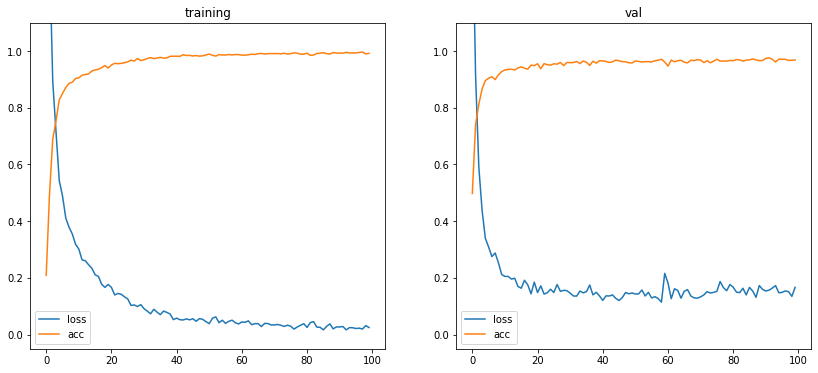

In [10]:
# ----------- PLOTS OF TRAINING ------------- #

# training plots
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(train_losses, label='loss')
plt.plot(train_accs, label='acc')
plt.ylim([-0.05,1.1])
plt.title('training')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_losses, label='loss')
plt.plot(val_accs, label='acc')
plt.ylim([-0.05,1.1])
plt.title('val')
plt.legend();

In [11]:
# ----------- SAVE THE MODEL ------------- #

# save model
torch.save(model.state_dict(), 'maib_model.h5')